In [55]:
from __future__ import annotations

import pickle

import matplotlib.pyplot as plt
import numpy as np
from edpyt.dmft import DMFT, Gfimp
from edpyt.nano_dmft import Gfimp as nanoGfimp
from edpyt.nano_dmft import Gfloc
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.projector import expand
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from qtpyt.block_tridiag import greenfunction
from qtpyt.projector import ProjectedGreenFunction

plt.rcParams.update({
    'font.size': 14,           # Increase the font size
    'font.weight': 'bold',     # Make the font bold
    'axes.labelsize': 16,      # Axis label size
    'axes.titlesize': 18,      # Title size
    'axes.labelweight': 'bold',  # Bold axis labels
    'xtick.labelsize': 14,     # X-axis tick label size
    'ytick.labelsize': 14,     # Y-axis tick label size
    'xtick.major.width': 1.2,  # X-axis major tick width
    'ytick.major.width': 1.2,  # Y-axis major tick width
    'axes.linewidth': 1.5,     # Axis line width
})


In [56]:
class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_molecule, super().retarded(energy), idx_molecule)


def load(filename):
    return DataSelfEnergy(energies, np.load(filename))


def distance(delta):
    global delta_prev
    delta_prev[:] = delta
    return dmft.distance(delta)


def save_sigma(sigma_diag, outputfile, npsin):
    L, ne = sigma_diag.shape
    sigma = np.zeros((ne, L, L), complex)

    def save(spin):
        for diag, mat in zip(sigma_diag.T, sigma):
            mat.flat[:: (L + 1)] = diag
        np.save(outputfile, sigma)

    for spin in range(nspin):
        save(spin)

In [57]:
def plot(gf, sigma_func, semilogy=True, reference_gf=None, label_ref="DFT"):
    """Plot the Green's function DOS and Tr(Sigma) with an optional reference DOS."""

    fig, axes = plt.subplots(2, 1, sharex=True)
    ax1, ax2 = axes

    w = z_ret.real
    dos = -1 / np.pi * gf(z_ret).sum(0).imag
    if semilogy:
        ax1.semilogy(w, dos, label="DMFT") if dos.ndim == 1 else ax1.semilogy(
            w, dos[0], label=r"spin $\uparrow$"
        )
    else:
        ax1.plot(w, dos, label="DMFT") if dos.ndim == 1 else ax1.plot(
            w, dos[0], label=r"spin $\uparrow$"
        )

    if reference_gf is not None:
        reference_dos = -1 / np.pi * reference_gf(z_ret).sum(0).imag
        ax1.plot(
            w, reference_dos, linestyle="--", label=label_ref
        ) if reference_dos.ndim == 1 else ax1.plot(
            w,
            reference_dos[0],
            linestyle="--",
            label=label_ref,
        )

    ax1.set_ylabel("DOS [a.u.]")
    ax1.legend(loc="upper right")

    ax1.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    sigma = sigma_func(z_ret)
    trace_sigma = sigma.sum(axis=0)
    ax2.plot(w, trace_sigma.real, label="Re Tr(Sigma)", color="blue")
    ax2.plot(w, trace_sigma.imag, label="Im Tr(Sigma)", color="orange")

    ax2.set_xlabel("E-E$_F$ [eV]")
    ax2.set_ylabel("Tr(Sigma) [eV]")
    ax2.legend(loc="upper right")

    plt.subplots_adjust(hspace=0)
    return ax1


def callback(*args, **kwargs):
    # gfloc.Hybrid = HybRet
    _ = plot(
        gf=gfloc,
        sigma_func=gfloc.Sigma,
        reference_gf=gfloc0,
        label_ref="DFT",
        semilogy=kwargs.get("semilogy", True),
    )
    # gfloc.Hybrid = HybRet
    plt.xlim(-0.5, 0.5)
    plt.show()
    plt.close()

In [58]:
nbaths = 4
U = 4.0
adjust_mu = True
use_double_counting = True

tol = 1e-4
max_iter = 1000
alpha = 0.0
nspin = 1
data_folder = "output/lowdin"

occupancy_goal = np.load(f"{data_folder}/occupancies.npy")
H_active = np.load(f"{data_folder}/bare_hamiltonian.npy").real
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
dft_dos = np.load(f"{data_folder}/dft_dos.npy")
self_energy = np.load(f"{data_folder}/self_energy.npy",allow_pickle=True)

with open(f"{data_folder}/hs_list_ii.pkl", "rb") as f:
	hs_list_ii = pickle.load(f)

with open(f"{data_folder}/hs_list_ij.pkl", "rb") as f:
	hs_list_ij = pickle.load(f)

len_active = occupancy_goal.size
de = 0.01
energies = np.arange(-2, 2 + de / 2.0, de).round(7)
eta = 5e-3
z_ret = energies + 1.j * eta
beta = 1000
z_mats = np.load(f"{data_folder}/matsubara_energies.npy")

In [59]:
# Green's Function Setup
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [(0, self_energy[0]), (len(hs_list_ii) - 1, self_energy[1])],
    solver="dyson",
    eta=eta,
    mu=1e-3,
    kt=1 / beta,
)
gfp = ProjectedGreenFunction(gf, index_active_region)

In [60]:
hyb_mats = np.fromfile(f"{data_folder}/matsubara_hybridization.bin", complex).reshape(
    z_mats.size,
    len_active,
    len_active,
)
_HybMats = interp1d(z_mats.imag, hyb_mats, axis=0, bounds_error=False, fill_value=0.0)
HybMats = lambda z: _HybMats(z.imag)

hyb_ret = np.fromfile(f"{data_folder}/hybridization.bin", complex).reshape(
    z_ret.size,
    len_active,
    len_active,
)
_HybRet = interp1d(z_ret.real, hyb_ret, axis=0, bounds_error=False, fill_value=0.0)
HybRet = lambda z: _HybRet(z.real)

# HybMats = lambda z: 0.0
# HybRet = lambda z: 0.0

S_active = np.eye(len_active)
idx_neq = np.arange(len_active)
idx_inv = np.arange(len_active)

V = np.eye(len_active) * U

# Apply double counting correction if specified
double_counting = (
    np.diag(V.diagonal() * (occupancy_goal - 0.5))
    if use_double_counting
    else np.zeros((len_active, len_active))
)
gfloc = Gfloc(
    H_active - double_counting,
    S_active,
    HybMats,
    idx_neq,
    idx_inv,
    nmats=z_mats.size,
    beta=beta,
)

nimp = gfloc.idx_neq.size
gfimp = [Gfimp(nbaths, z_mats.size, V[i, i], beta) for i in range(nimp)]
gfimp = nanoGfimp(gfimp)

In [61]:
Sigma = lambda z: np.zeros((nimp, z.size), complex)

In [62]:
gfloc0 = Gfloc(H_active ,S_active, HybMats, idx_neq, idx_inv, nmats=z_mats.size, beta=beta)
gfloc0.update(mu=1e-3)
gfloc0.set_local(Sigma)
dos = -1 / np.pi * gfloc0(z_ret).sum(0).imag
x, peaks = find_peaks(dos, height=5)
z_ret[x]

array([0.+0.005j])

In [67]:
def plot_atomic_positions_with_occupancy(atoms, element_colors, occupancy,title):

    fig, ax = plt.subplots(figsize=(10, 10))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    occupancy_index = 0
    for i, (xi, yi, atom) in enumerate(zip(x, y, atoms)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


        if atom.symbol in ['C', 'N']:
            ax.text(
                xi + 0.2, yi,
                f"{occupancy[occupancy_index]:.2f}",
                color='blue', fontsize=9, ha='left', va='center'
            )
            occupancy_index += 1

    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title(title)

    plt.show()


In [64]:
from ase.io import read
atoms = read('dft/device/scatt.xyz')
filtered_atoms = atoms[[atom.symbol not in ['H', 'Au'] for atom in atoms]]
element_colors = {'C': 'cyan', 'N': 'green'}

Total occupancy =  10.9453333790679


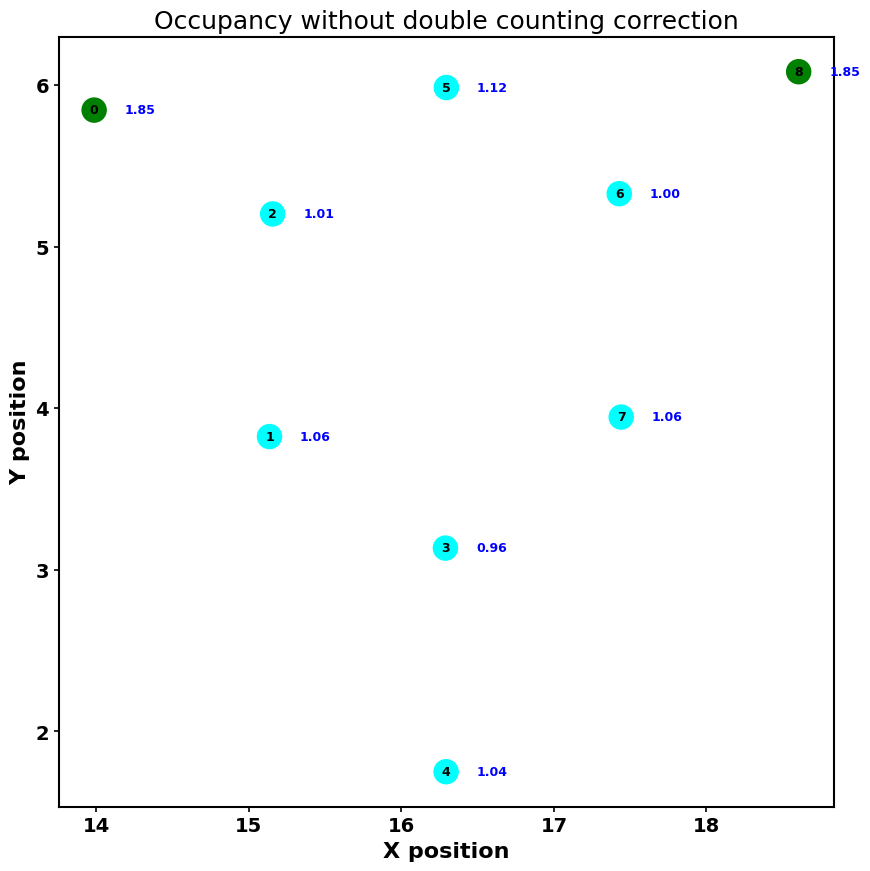

In [68]:
occupancy_no_dc_correction = gfloc0.integrate(mu=1e-3)
print("Total occupancy = ", occupancy_no_dc_correction.sum())
plot_atomic_positions_with_occupancy(filtered_atoms, element_colors, occupancy_no_dc_correction,title="Occupancy without double counting correction")

Total occupancy =  11.779791815168299


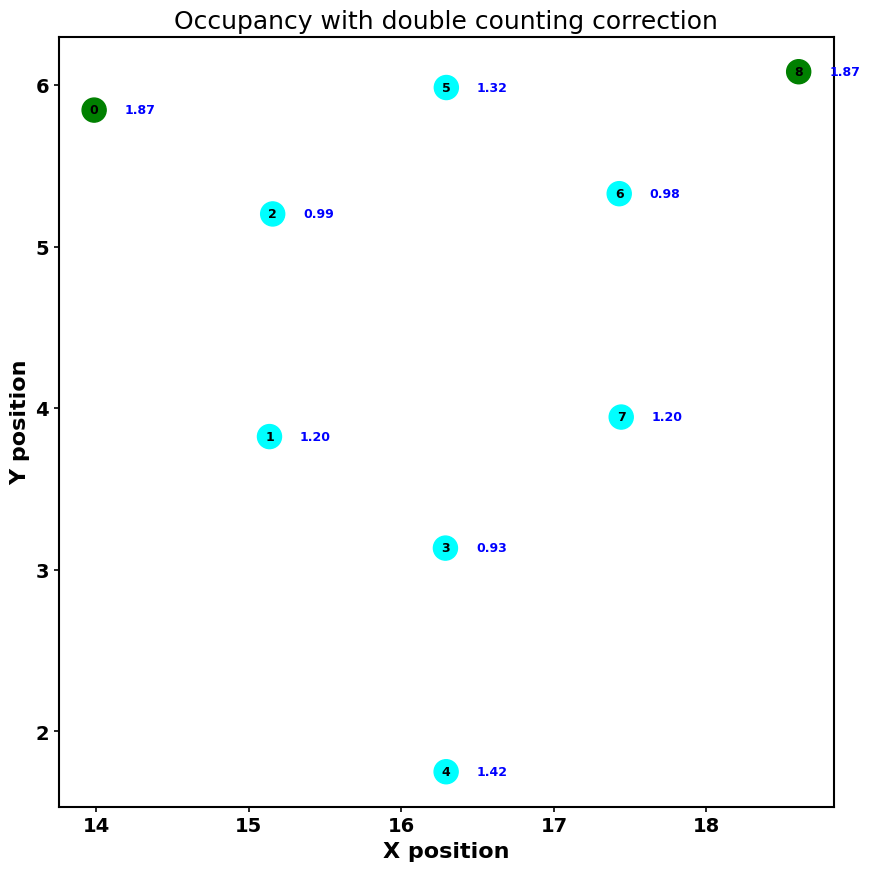

In [69]:
gfloc.update(mu=-0.25)
gfloc.set_local(Sigma)
occupancy_dc_correction = gfloc.integrate(mu=-0.25)
print("Total occupancy = ", occupancy_dc_correction.sum())
plot_atomic_positions_with_occupancy(filtered_atoms, element_colors, occupancy_dc_correction,title="Occupancy with double counting correction")

In [9]:
gfloc = Gfloc(H_active - double_counting ,S_active, HybMats, idx_neq, idx_inv, nmats=z_mats.size, beta=beta)
gfloc.update(mu=1e-3)
gfloc.set_local(Sigma)
dos_dc = -1 / np.pi * gfloc(z_ret).sum(0).imag
x, peaks = find_peaks(dos_dc, height=5)
z_ret[x]

array([0.+0.005j])

/home/anooja/miniconda3/envs/guido-edpyt-qtpyt/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/anooja/miniconda3/envs/guido-edpyt-qtpyt/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'E (eV)')

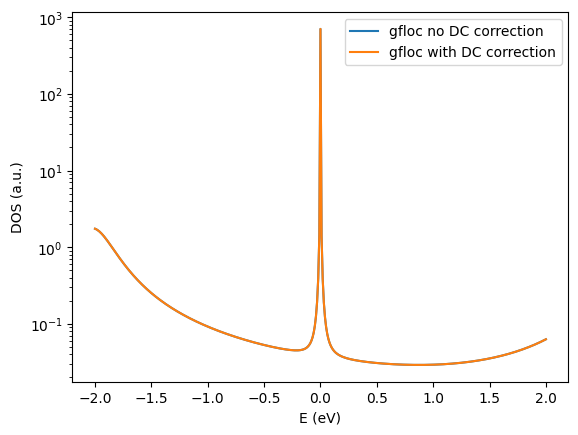

In [10]:
plt.plot(z_ret, dos,label="gfloc no DC correction")
plt.plot(z_ret, dos_dc,label="gfloc with DC correction")
# plt.plot(z_ret,dft_dos,label="dft")
plt.yscale("log")
plt.legend()
plt.ylabel("DOS (a.u.)")
plt.xlabel("E (eV)")
# plt.vlines(z_ret[x], 0, 10, colors="k")

In [11]:
occupancy_goal_ = occupancy_goal[gfloc.idx_neq]
# occupancy_goal_ = gfloc0.integrate(0.1014339185904589)
# print(occupancy_goal_qtpyt.sum())
print(occupancy_goal_.sum())

10.787299188461565


In [12]:
import scipy

f = lambda mu: gfloc.integrate(mu).sum() - occupancy_goal_.sum()

scipy.optimize.root_scalar(f, method='brentq', bracket=[-20, 20])

      converged: True
           flag: 'converged'
 function_calls: 22
     iterations: 21
           root: 0.0009271494250084713

In [13]:
# Initialize DMFT with adjust_mu parameter
dmft = DMFT(
    gfimp,
    gfloc,
    occupancy_goal_,
    max_iter=max_iter,
    tol=tol,
    adjust_mu=adjust_mu,
    alpha=alpha,
    DC=double_counting,
)

In [14]:
delta = dmft.initialize(V.diagonal().mean(), Sigma, mu=1e-3)
delta_prev = delta.copy()
dmft.delta = delta

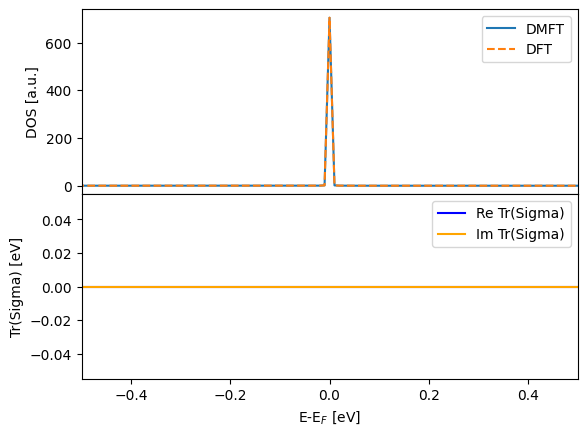

Iteration :  0
Occupation : 10.78730 Chemical potential : 0.00093 Error : 0.30934767 Relative Error : 0.00045549
Iteration :  1
Occupation : 10.78730 Chemical potential : 0.00093 Error : 0.00000000 Relative Error : 0.00000000


Converged: Converged!

In [15]:
dmft.it = 0
dmft.solve(dmft.delta, alpha=1.0, callback=callback(semilogy=False))

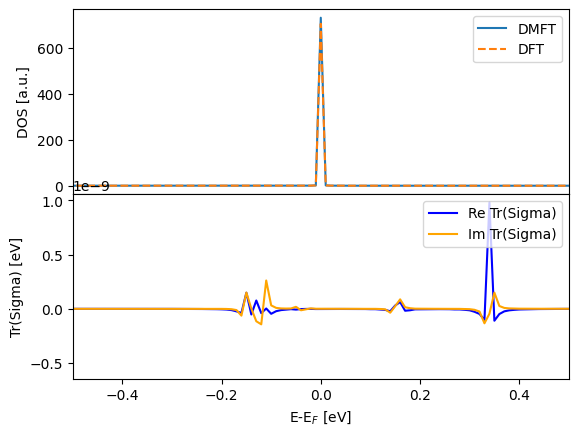

In [16]:
callback(semilogy=False)

In [17]:
_Sigma = lambda z: -double_counting.diagonal()[:, None] - gfloc.mu + gfloc.Sigma(z)[idx_inv]

dmft_sigma_file = f"{data_folder}/dmft_U0_sigma.npy"
save_sigma(_Sigma(z_ret), dmft_sigma_file,nspin)

In [18]:
z_ret.shape

(401,)

In [19]:
_Sigma(z_ret).shape

(9, 401)

In [21]:
energies.shape

(401,)